In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#  LOAD DATASET

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.head()

,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
0,Manhattan,NaN,2.0,82.5,15.0,254.0,3
1,Manhattan,Private room,2.0,53.7,1.0,0.0,1
2,Brooklyn,Private room,2.0,47.8,70.0,90.0,1
3,Manhattan,Entire home/apt,2.0,58.8,1.0,NaN,1
4,Bronx,Private room,2.0,32.2,0.0,89.0,1


In [3]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 41348 entries, 0 to 41347
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  40509 non-null  str    
 1   room_type            40737 non-null  str    
 2   minimum_nights       40026 non-null  float64
 3   amenity_score        40432 non-null  float64
 4   number_of_reviews    40225 non-null  float64
 5   availability_365     40753 non-null  float64
 6   price_class          41348 non-null  int64  
dtypes: float64(4), int64(1), str(2)
memory usage: 2.2 MB


In [4]:
# CHECK NULL VALUES

df_train.isnull().sum()

neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64

In [5]:
# ENCODE CATEGORICAL COLUMNS

df_train.replace({

    "room_type" : {
        "Entire home/apt" : 1,
        "Private room" : 2, 
        "Shared room" : 3
        },

    "neighbourhood_group" : {
        "Manhattan" : 1, 
        "Brooklyn" : 2, 
        "Queens" : 3, 
        "Bronx" : 4,
        "Staten Island" : 5}
}, inplace=True)

df_test.replace({

    "room_type" : {
        "Entire home/apt" : 1,
        "Private room" : 2, 
        "Shared room" : 3
        },

    "neighbourhood_group" : {
        "Manhattan" : 1, 
        "Brooklyn" : 2, 
        "Queens" : 3, 
        "Bronx" : 4,
        "Staten Island" : 5}
}, inplace=True)

df_train["room_type"] = df_train["room_type"].astype("Int64")
df_train["neighbourhood_group"] = df_train["neighbourhood_group"].astype("Int64")

df_test["room_type"] = df_test["room_type"].astype("Int64")
df_test["neighbourhood_group"] = df_test["neighbourhood_group"].astype("Int64")

In [6]:
# REMOVE OUTLIERS

cols_to_clean = ['minimum_nights', 'number_of_reviews']

df_no_outliers = df_train.copy()  

for col in cols_to_clean:
    Q1 = df_no_outliers[col].quantile(0.1)
    Q3 = df_no_outliers[col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_no_outliers = df_no_outliers[
        (df_no_outliers[col] >= lower_bound) &
        (df_no_outliers[col] <= upper_bound)
    ]

for col in cols_to_clean:
    df_test[col] = df_test[col].clip(lower=lower_bound, upper=upper_bound)

print("Original rows:", len(df_train))
print("Rows after removing outliers:", len(df_no_outliers))

df_no_outliers.describe()

Original rows: 41348
Rows after removing outliers: 38022


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
count,37248.0,37466.0,38022.000000,37196.000000,38022.000000,37470.000000,38022.000000
mean,1.74361,1.506299,5.978144,52.035867,20.071879,112.820016,1.233707
std,0.809365,0.546247,9.012729,19.526399,32.798348,131.367536,0.761596
min,1.0,1.0,1.000000,10.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.000000,36.800000,1.000000,0.000000,1.000000
50%,2.0,1.0,3.000000,51.500000,5.000000,46.000000,1.000000
75%,2.0,2.0,5.000000,66.200000,23.000000,225.000000,2.000000
max,5.0,3.0,70.000000,99.000000,180.000000,365.000000,3.000000


In [7]:
# FILL MISSING WITH MEAN VALUE

columns_to_fill = ['minimum_nights', 'number_of_reviews', 'availability_365']
df_num_filled = df_no_outliers.copy()

for col in columns_to_fill:
    mean_value = df_num_filled[col].mean()
    df_num_filled[col] = df_num_filled[col].fillna(mean_value)
    
    df_test[col] = df_test[col].fillna(mean_value)


print(df_num_filled[columns_to_fill].isna().sum())

df_num_filled.info()


minimum_nights       0
number_of_reviews    0
availability_365     0
dtype: int64
<class 'pandas.DataFrame'>
Index: 38022 entries, 0 to 41347
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  37248 non-null  Int64  
 1   room_type            37466 non-null  Int64  
 2   minimum_nights       38022 non-null  float64
 3   amenity_score        37196 non-null  float64
 4   number_of_reviews    38022 non-null  float64
 5   availability_365     38022 non-null  float64
 6   price_class          38022 non-null  int64  
dtypes: Int64(2), float64(4), int64(1)
memory usage: 2.4 MB


In [8]:
# FILL MISSING USING KNN

columns_to_fill = ['neighbourhood_group', 'room_type', 'amenity_score']

df_filled = df_num_filled.copy()
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_filled[columns_to_fill] = imputer.fit_transform(df_filled[columns_to_fill])

df_test[columns_to_fill] = imputer.transform(df_test[columns_to_fill])

print(df_filled[columns_to_fill].isna().sum())

df_filled["room_type"] = df_filled["room_type"].round().astype(int)
df_filled["neighbourhood_group"] = df_filled["neighbourhood_group"].round().astype(int)

df_test["room_type"] = df_test["room_type"].round().astype(int)
df_test["neighbourhood_group"] = df_test["neighbourhood_group"].round().astype(int)

neighbourhood_group    0
room_type              0
amenity_score          0
dtype: int64


In [9]:
df_filled.describe()

,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
count,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000
mean,1.744043,1.509205,5.978144,51.989759,20.071879,112.820016,1.233707
std,0.804550,0.545557,9.012729,19.410283,32.798348,130.410433,0.761596
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,37.000000,1.000000,0.000000,1.000000
50%,2.000000,1.000000,3.000000,51.500000,5.000000,51.000000,1.000000
75%,2.000000,2.000000,5.000000,66.100000,23.000000,221.000000,2.000000
max,5.000000,3.000000,70.000000,99.000000,180.000000,365.000000,3.000000


In [10]:
# NORMALIZE NUMERICAL COLUMNS

from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']

scaler = MinMaxScaler()
df_normalised = df_filled.copy()
df_normalised[columns_to_normalize] = scaler.fit_transform(df_normalised[columns_to_normalize])

df_test[columns_to_normalize] = scaler.transform(df_test[columns_to_normalize])

df_normalised.describe()


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
count,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000,38022.000000
mean,1.744043,1.509205,0.072147,0.471795,0.111510,0.309096,1.233707
std,0.804550,0.545557,0.130619,0.218093,0.182213,0.357289,0.761596
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.303371,0.005556,0.000000,1.000000
50%,2.000000,1.000000,0.028986,0.466292,0.027778,0.139726,1.000000
75%,2.000000,2.000000,0.057971,0.630337,0.127778,0.605479,2.000000
max,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [11]:
# DATA PREPERATION FOR DOWNSTREAM

from train import train_val_split

X = df_normalised[["neighbourhood_group", "room_type", "minimum_nights", "amenity_score", "number_of_reviews", "availability_365"]].to_numpy()
Y = df_normalised[["price_class"]].to_numpy()


x_test = df_test[["neighbourhood_group", "room_type", "minimum_nights", "amenity_score", "number_of_reviews", "availability_365"]].to_numpy()
y_test = df_test[["price_class"]].to_numpy()

x_train, x_val, y_train, y_val = train_val_split(X, Y)

In [12]:
# TRAINING USING SIGMOID

from train import fit

train_loss, val_loss, w_avg, t_acc, v_acc, w, b = fit(
                                        train_data=x_train, 
                                        val_data=x_val, 
                                        train_y=y_train, 
                                        val_y=y_val, 
                                        activation="sigmoid", 
                                        epochs=300, 
                                        learning_rate=0.001)

Epoch    | Train Loss      | Val Loss       
---------------------------------------------
50       | 3.089703        | 3.094588       
100      | 2.377538        | 2.387004       
150      | 2.055483        | 2.064599       
200      | 1.878298        | 1.885106       
250      | 1.757007        | 1.761333       
300      | 1.664527        | 1.666650       


In [ ]:
# TESTING USING SIGMOID

from evaluate import test_model
result = test_model(x_test, y_test, w, b, 2, "sigmoid")

Test Loss:     1.685412
Test Accuracy: 0.54%


(np.float64(1.6854123752848882), np.float64(0.544196245032205))

In [17]:
# TRAINING USING RELU

train_loss_relu, val_loss_relu, w_avg_relu, t_acc_relu, v_acc_relu, w_relu, b_relu = fit(
                                                                train_data=x_train, 
                                                                val_data=x_val, 
                                                                train_y=y_train, 
                                                                val_y=y_val, 
                                                                activation="relu", 
                                                                epochs=300,
                                                                learning_rate=0.001)

Epoch    | Train Loss      | Val Loss       
---------------------------------------------
50       | 6.043637        | 5.757285       
100      | 4.436556        | 4.246255       
150      | 3.572298        | 3.415136       
200      | 2.893053        | 2.758367       
250      | 2.337406        | 2.221607       
300      | 1.944064        | 1.848452       


In [ ]:
# TESTING USING SIGMOID

from evaluate import test_model
result = test_model(x_test, y_test, w_relu, b_relu, 2, "relu")

Test Loss:     2.614873
Test Accuracy: 0.42%


(np.float64(2.6148727576620816), np.float64(0.42209127038508976))

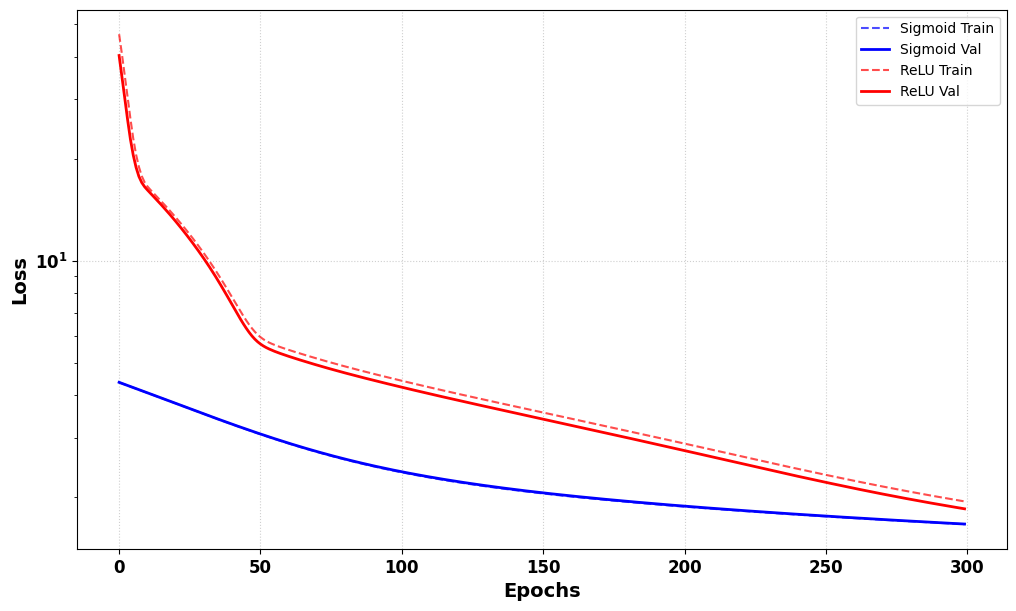

In [ ]:
# PLOT LOSSES

epochs = range(len(train_loss_relu))

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, label='Sigmoid Train', color='blue', linestyle='--', alpha=0.7)
plt.plot(epochs, val_loss, label='Sigmoid Val', color='blue', linewidth=2)

plt.plot(epochs, train_loss_relu, label='ReLU Train', color='red', linestyle='--', alpha=0.7)
plt.plot(epochs, val_loss_relu, label='ReLU Val', color='red', linewidth=2)

plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.yscale('log')
plt.savefig("images/loss_curve.png")
plt.show()

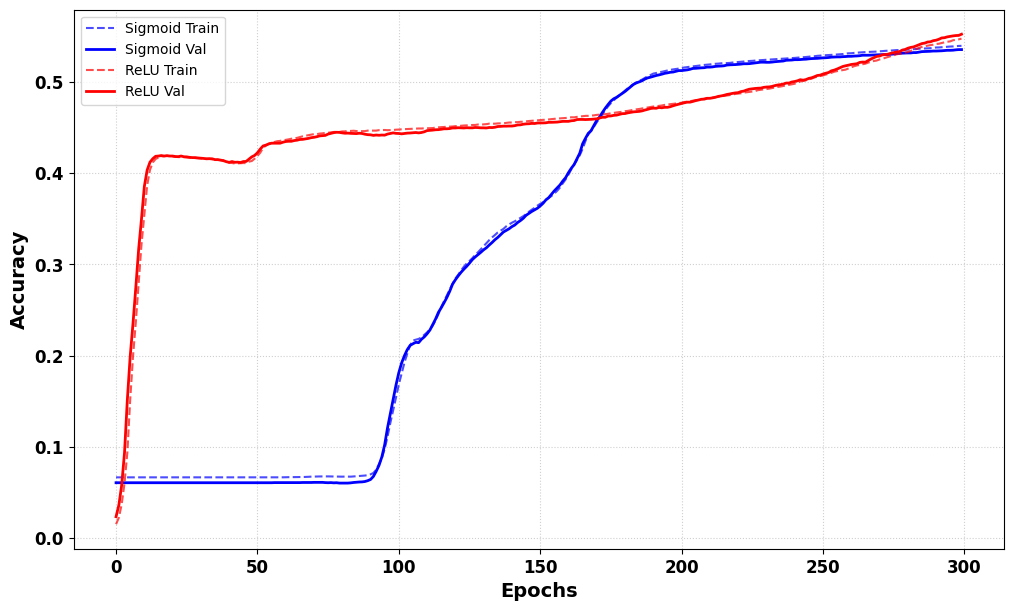

In [ ]:
# PLOT ACCURACY

epochs = range(len(t_acc_relu))

plt.figure(figsize=(12, 7))

plt.plot(epochs, t_acc, label='Sigmoid Train', color='blue', linestyle='--', alpha=0.7)
plt.plot(epochs, v_acc, label='Sigmoid Val', color='blue', linewidth=2)

plt.plot(epochs, t_acc_relu, label='ReLU Train', color='red', linestyle='--', alpha=0.7)
plt.plot(epochs, v_acc_relu, label='ReLU Val', color='red', linewidth=2)

plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.savefig("images/acc_curve.png")
plt.show()

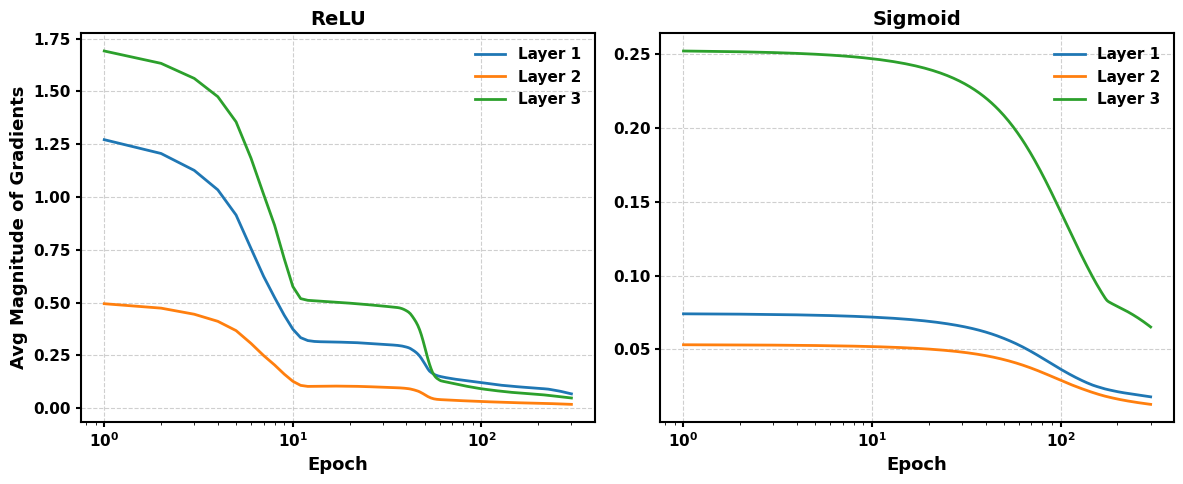

In [ ]:
# PLOT GRADIENTS

plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5
})

fig, axes = plt.subplots(1, 2, figsize=(12,5))

epochs = range(1, w_avg_relu.shape[0] + 1)

for layer in range(w_avg_relu.shape[1]):
    axes[0].plot(epochs, w_avg_relu[:, layer], linewidth=2,
                 label=f"Layer {layer+1}")

axes[0].set_title("ReLU", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Avg Magnitude of Gradients", fontsize=13, fontweight="bold")
axes[0].set_xscale("log")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(frameon=False, fontsize=11)

axes[0].tick_params(axis='both', labelsize=11, width=1.5)
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    label.set_fontweight('bold')


for layer in range(w_avg.shape[1]):
    axes[1].plot(epochs, w_avg[:, layer], linewidth=2,
                 label=f"Layer {layer+1}")

axes[1].set_title("Sigmoid", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch", fontsize=13, fontweight="bold")
axes[1].set_xscale("log")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(frameon=False, fontsize=11)

axes[1].tick_params(axis='both', labelsize=11, width=1.5)
for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
    label.set_fontweight('bold')


plt.tight_layout()
plt.savefig("images/gradient_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [22]:
print("Final Accuracy of Sigmoid:")
print(f"     Training: {t_acc[-1]:.2f}")
print(f"     Validation: {v_acc[-1]:.2f}")
print("Final Accuracy of ReLU:")
print(f"     Training: {t_acc_relu[-1]:.2f}")
print(f"     Validation: {v_acc_relu[-1]:.2f}")

Final Accuracy of Sigmoid:
     Training: 0.54
     Validation: 0.54
Final Accuracy of ReLU:
     Training: 0.55
     Validation: 0.55


In [23]:
# DEFINE PYTORCH MODEL

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(6, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward_pass(self, x):
        a1 = self.layer1(x)
        x1 = self.relu(a1)
        a2 = self.layer2(x1)
        x2 = self.relu(a2)
        a3 = self.layer3(x2)
        return a3
    
    def input_grads(self, x_train, y_train):
        x = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
        y = torch.tensor(y_train, dtype=torch.long).squeeze()
        criterion = nn.CrossEntropyLoss()
        a3 = self.forward_pass(x)
        loss = criterion(a3, y)
        self.zero_grad()
        loss.backward()
        x_grad = torch.abs(x.grad).mean(dim=0)
        return torch.argsort(x_grad, descending=True), x_grad
        

In [24]:
# TRAIN PYTORCH MODEL

model = NeuralNetwork() 
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(
    torch.tensor(x_train, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.long).squeeze()
)
train_loader = DataLoader(train_ds, batch_size=len(x_train))

val_ds = TensorDataset(
    torch.tensor(x_val, dtype=torch.float32), 
    torch.tensor(y_val, dtype=torch.long).squeeze()
)
val_loader = DataLoader(val_ds, batch_size=len(x_val))

train_losses_pytorch = []
val_losses_pytorch = []
train_acc_pytorch = []
val_acc_pytorch = []

print(f"{'Epoch':<8} | {'Train Loss':<15} | {'Val Loss':<15}")
print("-" * 45)

for epoch in range(300):
    model.train()
    running_train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()          
        outputs = model.forward_pass(batch_x)        
        loss = criterion(outputs, batch_y)
        loss.backward()                
        optimizer.step()                
        
        running_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    train_losses_pytorch.append(avg_train_loss)
    train_acc_pytorch.append(train_accuracy)

    model.eval() 
    running_val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_outputs = model.forward_pass(val_x)
            v_loss = criterion(val_outputs, val_y)
            running_val_loss += v_loss.item()
            
            _, predicted = torch.max(val_outputs.data, 1)
            val_total += val_y.size(0)
            val_correct += (predicted == val_y).sum().item()
            
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    val_losses_pytorch.append(avg_val_loss)
    val_acc_pytorch.append(val_accuracy)

    if (epoch + 1) % 50 == 0:
            print(f"{epoch+1:<8} | {avg_train_loss:<15.6f} | {avg_val_loss:<15.6f}")

Epoch    | Train Loss      | Val Loss       
---------------------------------------------
50       | 1.231282        | 1.228224       
100      | 1.150314        | 1.148307       
150      | 1.121529        | 1.119346       
200      | 1.109795        | 1.106873       
250      | 1.102130        | 1.098533       
300      | 1.095897        | 1.091758       


In [25]:
# GET FEATURE GRADIENTS AND RANKS

feature_names = ["neighbourhood_group", "room_type", "minimum_nights", 
                 "amenity_score", "number_of_reviews", "availability_365"]


importance_scores = model.input_grads(x_train, y_train)

ranks = importance_scores[0].tolist()

sorted_idx = torch.argsort(importance_scores[1], descending=True)
print("--- Ranked Feature Importance ---")
for i, idx in enumerate(sorted_idx):
    print(f"{i+1}. {feature_names[idx]}:   {importance_scores[1][idx]:.7f}")

--- Ranked Feature Importance ---
1. room_type:   0.0000037
2. neighbourhood_group:   0.0000033
3. minimum_nights:   0.0000023
4. amenity_score:   0.0000016
5. number_of_reviews:   0.0000013
6. availability_365:   0.0000009


In [ ]:
# ACCURACIES OF PYTORCH MODEL

print("Final Accuracy of Pytorch Model:")
print(f"     Training: {train_acc_pytorch[-1]:.2f}")
print(f"     Validation: {val_acc_pytorch[-1]:.2f}")

Final Accuracy of Pytorch Model:
     Training: 56.19
     Validation: 55.91


In [ ]:
# TEST PYTORCH MODEL

test_ds = TensorDataset(
    torch.tensor(x_test, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.long).squeeze()
)
test_loader = DataLoader(test_ds, batch_size=len(x_test))


model.eval() 
running_test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_outputs = model.forward_pass(test_x)
        
        t_loss = criterion(test_outputs, test_y)
        running_test_loss += t_loss.item()
        
        _, predicted = torch.max(test_outputs.data, 1)
        test_total += test_y.size(0)
        test_correct += (predicted == test_y).sum().item()

avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"{"-"*30}")
print(f"FINAL TEST RESULTS")
print(f"{"-"*30}")
print(f"Test Loss:     {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

------------------------------
FINAL TEST RESULTS
------------------------------
Test Loss:     1.0992
Test Accuracy: 56.31%


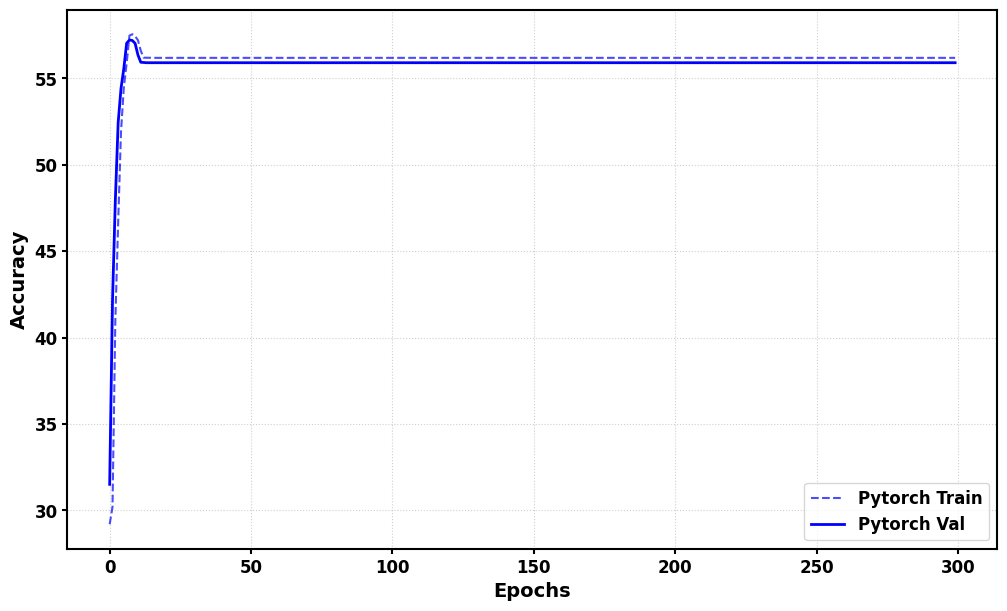

In [ ]:
# PLOT ACCURACY

epochs = range(len(train_acc_pytorch))

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_acc_pytorch, label='Pytorch Train', color='blue', linestyle='--', alpha=0.7)
plt.plot(epochs, val_acc_pytorch, label='Pytorch Val', color='blue', linewidth=2)


plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.show()